In [14]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context(context='notebook',font_scale=1.5)
from gru.cc_utils import _get_clip_labels
%matplotlib inline

## Cross Validation Results

In [2]:
with open('results/clip_gru/roi_300_net_7_trainsize_100_kfold_5_batch_size_32_num_epochs_45_z_1_GSCV.pkl',"rb") as  f:
    results, params = pickle.load(f)

In [3]:
params

[{'k_hidden': 8, 'k_layers': 1},
 {'k_hidden': 16, 'k_layers': 1},
 {'k_hidden': 32, 'k_layers': 1},
 {'k_hidden': 64, 'k_layers': 1}]

In [4]:
df = pd.DataFrame.from_dict({(i,j): results[i][j] for i in results.keys()
                             for j in ['train','val']}).T

df.index.set_names(['model','dset'],inplace=True) 
df.reset_index(inplace=True)
df= df.melt(id_vars = ['model','dset'],var_name='fold',value_name='accuracy')
df.head()

,model,dset,fold,accuracy
0,model00,train,0,0.796489
1,model00,val,0,0.597011
2,model01,train,0,0.905513
3,model01,val,0,0.779390
4,model02,train,0,0.885189


Best val accuray of: 0.799


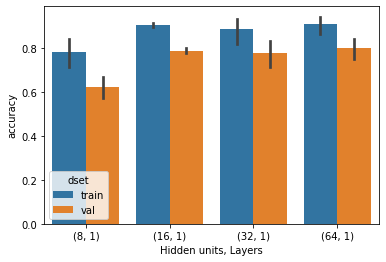

In [5]:
ax = sns.barplot(x='model',y='accuracy',data=df,hue='dset')
ax.set_xticklabels([(d['k_hidden'],d['k_layers']) for d in params])
ax.set_xlabel('Hidden units, Layers')
acc = df[df['dset']=='val'].groupby('model').mean().sort_values(by='accuracy',ascending=False).iloc[0,0]
opt_model = df[df['dset']=='val'].groupby('model').mean().sort_values(by='accuracy',ascending=False).head(1).index.item()
print('Best val accuray of: %.3f' %(acc))

In [7]:
df.groupby(['model','dset'])['accuracy'].agg([np.mean, np.std])

mean       std
model   dset                     
model00 train  0.784415  0.082186
        val    0.622970  0.061253
model01 train  0.905526  0.013029
        val    0.788021  0.014201
model02 train  0.888420  0.072363
        val    0.779981  0.079694
model03 train  0.908798  0.054683
        val    0.798944  0.059036

## Test Results

In [15]:
clip_y = _get_clip_labels()
k_class = len(np.unique(list(clip_y.values())))
print('number of classes = %d' %k_class)

clip_names = np.zeros(k_class).astype(str)
clip_names[0] = 'testretest'
for key, item in clip_y.items():
    if item!=0:
        clip_names[item] = key
        
res_path = 'results/clip_gru/'

number of classes = 15


In [16]:
with open('results/clip_gru/roi_300_net_7_trainsize_100_k_hidden_32_k_layers_1_batch_size_32_num_epochs_45_z_1.pkl',"rb") as  f:
    results, results_prob = pickle.load(f)

In [17]:
df = pd.DataFrame()
for dset in results_prob:
    for mov_i, movie in enumerate(clip_names):
        for t_prob in results_prob[dset]['t_prob'][mov_i]:
            tmp_df = pd.DataFrame(t_prob,columns=['probs'])
            tmp_df['acc'] = results_prob[dset]['acc']
            tmp_df['dset'] = dset
            tmp_df['movie'] =  movie
            tmp_df['time'] = np.arange(t_prob.shape[0])
            df = pd.concat([df,tmp_df],ignore_index=True)

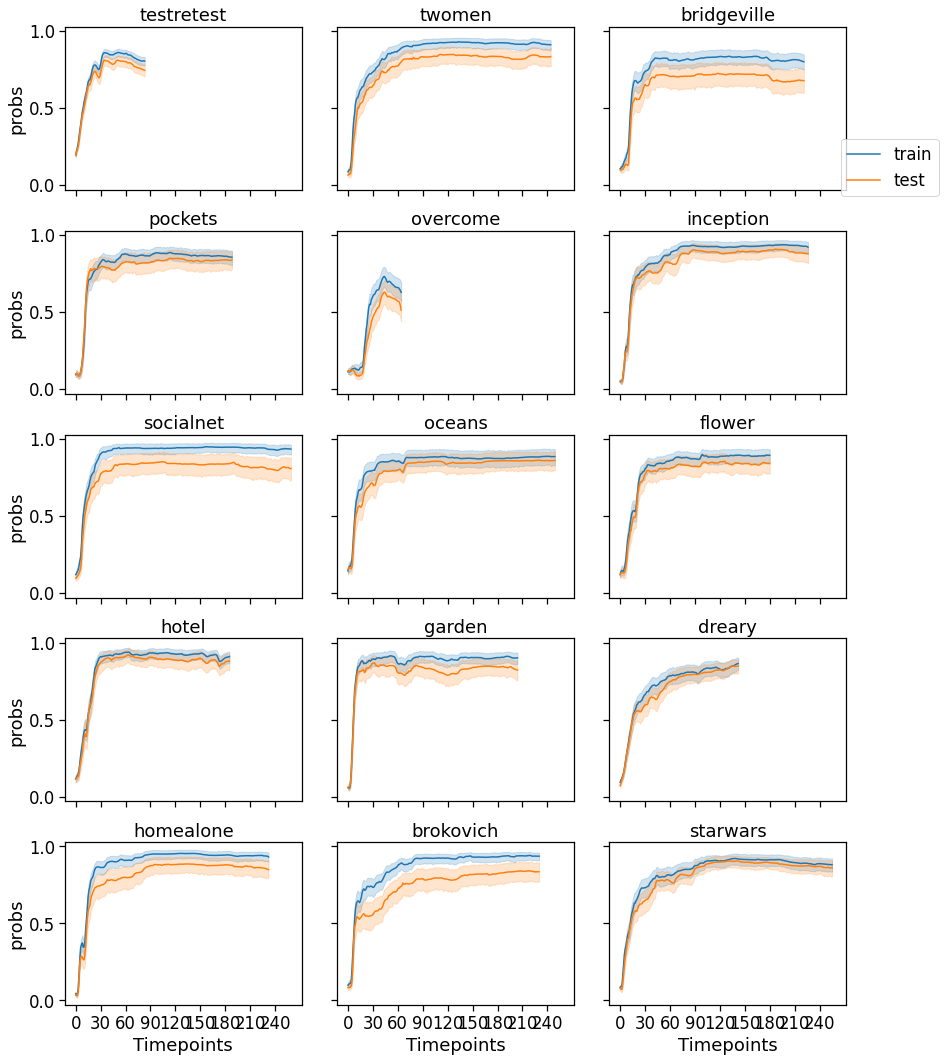

In [20]:
fig, axes = plt.subplots(ncols=3,nrows=5,figsize=(14,18),sharey=True,sharex=True)
axes = axes.flatten()

fig.subplots_adjust(hspace=0.25,wspace=0.15)

for mov_i, movie in enumerate(clip_names):
    movie_df = df[df['movie']==movie]
    sns.lineplot(x='time',y='probs',hue='dset',data=movie_df,ax=axes[mov_i],legend=False)
    axes[mov_i].set_title(movie)
    axes[mov_i].set_xlabel('Timepoints')
    axes[mov_i].set_xticks(np.arange(0,260,30))
    
fig.legend(['train','test'],bbox_to_anchor=[1,0.8])

In [21]:
train = pd.Series(results['train'],name='acc',index=np.arange(100)).to_frame()
test = pd.Series(results['test'],name='acc',index=np.arange(100,176)).to_frame()
result_table = pd.concat([train,test],axis=0)

result_table['dset'] = 'train'
result_table.loc[100:,'dset'] = 'test'

Mean train accuracy: 0.88
Mean test accuracy: 0.82


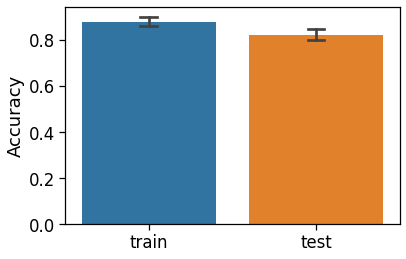

In [22]:
#plt.figure(figsize=(8,6))
sns.barplot(x='dset',y='acc',data=result_table,capsize=0.10)
plt.xlabel('')
_=plt.ylabel('Accuracy')
print('Mean train accuracy: %.2f'%train.mean().item())
print('Mean test accuracy: %.2f'%test.mean().item())